In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#多输入多输出
%tensorflow_version 2.x
import tensorflow as tf
!/opt/bin/nvidia-smi

Sun Sep 26 11:31:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Multiply, Lambda
from tensorflow.keras.layers import LSTM, GRU, Embedding, Flatten, Reshape, Layer, Average, Add, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv1D, Convolution1D, MaxPooling1D, concatenate, Input, Bidirectional, RepeatVector, Concatenate, Dot, Permute, TimeDistributed, SpatialDropout1D, AveragePooling1D, UpSampling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.optimizers import *
tf.compat.v1.disable_eager_execution()

In [4]:
#调用self attention
#!pip install keras-self-attention
#!pip uninstall keras-tcn --no-dependencies
#!kill -9 -1
#!pip install attention

In [5]:
#导入文件
#out版本
input_file="/content/drive/My Drive/Benchmark_PageGap/PageGap_RW/PageGap_526_RW.out" #521  
dataset=read_csv(input_file, header=None, index_col=None, sep=' ')
start=2800000  #5060000
end=3000000  #5260000
datasetRW=dataset[0].values[start:end]
#dataset.drop(, axis=1, inplace=True)
datasetD=dataset[1].values[start:end]
dataset


,0,1
0,0,43
1,0,-43
2,0,43
3,0,-43
4,0,40
...,...,...
8136228,0,-7552
8136229,0,0
8136230,1,7552
8136231,0,-7552


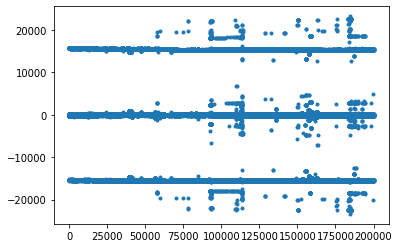

In [6]:
#查看数据分布
plt.plot(datasetD, '.')
plt.show()

In [7]:
#读写数据
datasetRW

array([0, 0, 0, ..., 1, 0, 0])

In [8]:
#delta数据
datasetD

array([     0,  15703, -15703, ...,   -241, -15296,  15537])

In [9]:
#提前先分好训练集和测试集
train_size = int(len(datasetD) * 0.8)
print(train_size)
train_Delta = datasetD[:train_size]
test_Delta = datasetD[train_size:]
train_RW = datasetRW[:train_size]
test_RW = datasetRW[train_size:]
print(train_Delta.shape)
print(test_Delta.shape)
print(train_RW.shape)
print(test_RW.shape)

160000
(160000,)
(40000,)
(160000,)
(40000,)


In [10]:
#将训练集的delta转成list和set
list_a=train_Delta.tolist()
print("Train_List长度：",len(list_a))

list_b=test_Delta.tolist()
print("Test_List长度：",len(list_b))

#查看delta的种类
set_a=set(list_a)
type_n_a=len(set_a)
print("Train_Set种类：",type_n_a)

set_b=set(list_b)
type_n_b=len(set_b)
print("Test_Set种类：",type_n_b)

Train_List长度： 160000
Test_List长度： 40000
Train_Set种类： 1304
Test_Set种类： 566


In [11]:
value_cnt_a = {}
for delta in list_a:
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	value_cnt_a[delta] = value_cnt_a.get(delta, 0) + 1

# 打印输出结果
print("Train字典收集训练集（delta类别-次数）：",value_cnt_a)
print("Train各delta值：",[key for key in value_cnt_a.keys()])
Vals_a=[delta for delta in value_cnt_a.values()]
print("Train各delta值的次数：",Vals_a)
print("Train_delta种类：",len(Vals_a))

value_cnt_b = {}
for delta in list_b:
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	value_cnt_b[delta] = value_cnt_b.get(delta, 0) + 1

# 打印输出结果
print("Test字典收集训练集（delta类别-次数）：",value_cnt_b)
print("Test各delta值：",[key for key in value_cnt_b.keys()])
Vals_b=[delta for delta in value_cnt_b.values()]
print("Test各delta值的次数：",Vals_b)
print("Test_delta种类：",len(Vals_b))

Train字典收集训练集（delta类别-次数）： {0: 33074, 15703: 32, -15703: 1, -256: 16200, -15447: 28, 256: 9467, -15446: 161, 15702: 163, 255: 354, -199: 1, -15247: 1, 1: 519, -15445: 162, 15701: 163, -201: 1, -15245: 1, 15488: 198, -15488: 82, -203: 1, -15242: 1, 213: 263, 15700: 146, -15444: 147, -15701: 1, -206: 1, -15239: 1, 212: 162, -207: 1, -15237: 1, -15443: 166, 15699: 149, -15700: 3, -210: 2, -15233: 1, 15698: 162, -15442: 135, 210: 193, 211: 196, -212: 6, -15486: 7, -15441: 133, 15697: 148, -15698: 24, -470: 1, -15484: 4, -15697: 16, 209: 135, -216: 1, -15481: 3, -15440: 154, 15696: 171, -219: 1, -15477: 4, -15439: 161, 15695: 160, -15696: 19, -220: 1, -15475: 4, 208: 185, 207: 173, -223: 40, -15472: 3, 15694: 132, -15438: 148, 206: 193, -15695: 1, -225: 61, -15469: 9, 15693: 156, -15437: 166, -15693: 2, -1: 318, -227: 159, -15466: 7, 205: 200, 15692: 155, -15436: 162, -230: 68, -15463: 1, -232: 1, -15460: 1, 203: 166, -15435: 153, 204: 194, 15691: 150, -234: 1, -15458: 2, 257: 338, -15692: 1

In [12]:
from random import randint
#统计delta计数较少的index，考虑归为新类
#字典收集训练集的delta值
value_cnt = {}
for delta in list_a:
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	value_cnt[delta] = value_cnt.get(delta, 0) + 1

# 打印输出结果
print("字典收集训练集（delta类别-次数）：",value_cnt)
print("各delta值：",[key for key in value_cnt.keys()])
Vals=[delta for delta in value_cnt.values()]
print("各delta值的次数：",Vals)
print("delta种类：",len(Vals))

Vals_Record=[delta for delta in value_cnt.keys() if value_cnt[delta] >5] #要保留记录的delta
Vals_Thr_Num=[delta for delta in Vals if delta >5] #要保留记录的delta次数
Vals_Thr_Dele=[delta for delta in value_cnt.keys() if value_cnt[delta] <=5] #次数小于等于10次的delta，归成一类
Vals_Thr_Dele_Num=[delta for delta in Vals if delta <=5] #要归为一类记录的delta次数
print("要保留的delta：",Vals_Record)
print("要保留的delta次数：",Vals_Thr_Num)
print("要保留的delta种类数：",len(Vals_Thr_Num))
#将不保留记录的delta都归为一个新类
type_new=len(Vals_Thr_Num)+1

print("要删除的delta：",Vals_Thr_Dele)
print("要删除的delta次数：",Vals_Thr_Num)
print("要删除的delta种类：",len(Vals_Thr_Dele))

#设置一个新类，统归为初始值0，利用随机生成一个0-type_new之间的数，作为最终新类值
init_val=0
while init_val in Vals_Record:
  init_val=randint(0,type_new)
print("新类的值: ",init_val)

#对于训练集，不保留的类都归为值：init_val
print(len(set(train_Delta)))
print('不保留的类都归为值：',init_val)
for i in Vals_Thr_Dele:
  train_Delta[train_Delta==i]=init_val

#对于测试集，同样将不保留的值归为：init_val
for i in range(len(test_Delta)):
  if test_Delta[i] not in Vals_Record:
    test_Delta[i]=init_val

print(set(test_Delta))

print(len(set(train_Delta)))
  



字典收集训练集（delta类别-次数）： {0: 33074, 15703: 32, -15703: 1, -256: 16200, -15447: 28, 256: 9467, -15446: 161, 15702: 163, 255: 354, -199: 1, -15247: 1, 1: 519, -15445: 162, 15701: 163, -201: 1, -15245: 1, 15488: 198, -15488: 82, -203: 1, -15242: 1, 213: 263, 15700: 146, -15444: 147, -15701: 1, -206: 1, -15239: 1, 212: 162, -207: 1, -15237: 1, -15443: 166, 15699: 149, -15700: 3, -210: 2, -15233: 1, 15698: 162, -15442: 135, 210: 193, 211: 196, -212: 6, -15486: 7, -15441: 133, 15697: 148, -15698: 24, -470: 1, -15484: 4, -15697: 16, 209: 135, -216: 1, -15481: 3, -15440: 154, 15696: 171, -219: 1, -15477: 4, -15439: 161, 15695: 160, -15696: 19, -220: 1, -15475: 4, 208: 185, 207: 173, -223: 40, -15472: 3, 15694: 132, -15438: 148, 206: 193, -15695: 1, -225: 61, -15469: 9, 15693: 156, -15437: 166, -15693: 2, -1: 318, -227: 159, -15466: 7, 205: 200, 15692: 155, -15436: 162, -230: 68, -15463: 1, -232: 1, -15460: 1, 203: 166, -15435: 153, 204: 194, 15691: 150, -234: 1, -15458: 2, 257: 338, -15692: 1, -15

In [13]:
trainl=test_Delta.tolist()
setl=set(trainl)
typel=len(setl)
print("Train_Set种类：",typel)

Train_Set种类： 104


In [14]:
#编码转换
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



#查看train_Delta和test_Delta种类：
listD_train=train_Delta.tolist()
listD_test=test_Delta.tolist()
set_d_train=set(listD_train)
set_d_test=set(listD_test)
print("查看train_Delta种类：",len(set_d_train))
print("查看test_Delta种类：",len(set_d_test))



查看train_Delta种类： 479
查看test_Delta种类： 104


In [15]:
train_Delta[500:590]

array([-15446,  15702,   -256,    256,   -256, -15446,      0,      0,
        15702,   -256, -15446,  15702,   -256,    256,   -256, -15445,
            0,      0,  15701,   -256, -15445,  15701,   -256,    256,
         -256, -15445,      0,      0,  15702,   -256, -15446,  15702,
         -256, -15446,      0,  15702,   -256, -15446,  15702,   -256,
       -15446,      0,  15702,   -256, -15446,  15702,   -256, -15446,
            0,      0,  15702,   -256,    256,   -256,    256,   -256,
          363,    363,  15702,   -256, -15446,  15702,   -256, -15446,
        15702,   -256, -15446,      0,  15702,   -256, -15446,  15702,
         -256, -15446,      0,  15702,   -256, -15446,  15702,   -256,
       -15446,      0,  15702,   -256, -15446,  15702,   -256, -15446,
        15702,   -256])

In [16]:
#编码的时候先合并train和test的数据，相当于用同样的方法transform
whole_delta=np.concatenate((train_Delta,test_Delta))
#integer encoding方法（LabelEncoder）
values=whole_delta
label_encoder=LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print("训练集推出的Integer_encoder：",integer_encoded)

#找种类的最大值
max_integer_encoded=max(integer_encoded)+1
print("最大的integer_encoded_num：",max_integer_encoded)
max_integer=type_new-1
num_bit=int(math.log(max_integer, 2)+1)
print("需要转的二进制：",max_integer)
print("应该用多少bit表示：",num_bit)

# define convert_to_binary method
# 每个值转特定位数的binary编码
def convert_to_binary(origin, num_bit=1):
  binary_encoded = []
  num_bit_str=str(num_bit)
  for element in origin:
    binary_encoded.append(list(map(int,list(('{:0'+num_bit_str+'b}').format(element)))))
  return np.array(binary_encoded)

binary_encoded = convert_to_binary(integer_encoded, num_bit)
print("Binary_encoded：",binary_encoded)

# define convert_to_onehot method
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("Onehot_encoded：",onehot_encoded)

训练集推出的Integer_encoder： [268 472 347 ... 347 226 347]
最大的integer_encoded_num： 479
需要转的二进制： 478
应该用多少bit表示： 9
Binary_encoded： [[1 0 0 ... 1 0 0]
 [1 1 1 ... 0 0 0]
 [1 0 1 ... 0 1 1]
 ...
 [1 0 1 ... 0 1 1]
 [0 1 1 ... 0 1 0]
 [1 0 1 ... 0 1 1]]
Onehot_encoded： [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:

print(type(integer_encoded))
print("整数编码shape：",integer_encoded.shape)
print(type(onehot_encoded))
print("独热编码shape：",onehot_encoded.shape)
print(type(binary_encoded))
print("二进制编码：",binary_encoded.shape)



<class 'numpy.ndarray'>
整数编码shape： (200000, 1)
<class 'numpy.ndarray'>
独热编码shape： (200000, 479)
<class 'numpy.ndarray'>
二进制编码： (200000, 9)


In [18]:
#读写数据
RW = datasetRW[:]
RW = np.reshape(RW, (RW.shape[0],1))
RW.shape

(200000, 1)

In [19]:
#创建数据集的输入和输出
def create_dataset(datasetX, datasetY, look_back=1, pridict_size=1):
	dataX, dataY = [], []
	for i in range(len(datasetX)-look_back-pridict_size):
		a = datasetX[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(datasetY[i + look_back:(i+look_back+pridict_size), :])
	return np.array(dataX), np.array(dataY)

In [20]:
#确定lookback的size
look_back = 80
pridict_size = 2
type_new

#按lookback的size创建训练集输入和输出,trainX的维度((train_size-look_back-pridict_size),look_back)
#训练集的数据
integer_encoded_train=integer_encoded[:train_size]
binary_encoded_train=binary_encoded[:train_size]
integer_encoded_test=integer_encoded[train_size:]
binary_encoded_test=binary_encoded[train_size:]
#训练集的读写数据
RW_train=RW[:train_size]
RW_test=RW[train_size:]

#valuesX, valuesY = create_dataset(integer_encoded, onehot_encoded, look_back, pridict_size)    #onehot_encoded
trainX, trainY = create_dataset(integer_encoded_train, binary_encoded_train, look_back, pridict_size)    #binary_encoded
testX, testY = create_dataset(integer_encoded_test, binary_encoded_test, look_back, pridict_size)

trainX_RW, trainY_RW = create_dataset(RW_train, RW_train, look_back, pridict_size) 
testX_RW, testY_RW = create_dataset(RW_test, RW_test, look_back, pridict_size)


print('TrainX Shape: ',trainX.shape)
print('TrainY Shape: ',trainY.shape)
print('TestX Shape: ',testX.shape)
print('TestY Shape: ',testY.shape)

print('TrainX_RW Shape: ',trainX_RW.shape)
print('TrainY_RW Shape: ',trainY_RW.shape)
print('TestX_RW Shape: ',testX_RW.shape)
print('TestY_RW Shape: ',testY_RW.shape)

TrainX Shape:  (159918, 80, 1)
TrainY Shape:  (159918, 2, 9)
TestX Shape:  (39918, 80, 1)
TestY Shape:  (39918, 2, 9)
TrainX_RW Shape:  (159918, 80, 1)
TrainY_RW Shape:  (159918, 2, 1)
TestX_RW Shape:  (39918, 80, 1)
TestY_RW Shape:  (39918, 2, 1)


In [21]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2]*trainX.shape[1]))
print("feature:",trainX.shape)
testX = np.reshape(testX, (testX.shape[0], testX.shape[2]*testX.shape[1]))
print('TrainX Shape: ',trainX.shape)
print('TrainY Shape: ',trainY.shape)

print('trainX type: ',type(trainX))

trainX_RW=np.reshape(trainX_RW, (trainX_RW.shape[0], trainX_RW.shape[2]*trainX_RW.shape[1]))
testX_RW = np.reshape(testX_RW, (testX_RW.shape[0], testX_RW.shape[2]*testX_RW.shape[1]))
print('trainX_RW Shape: ',trainX_RW.shape)
print('trainY_RW Shape: ',trainY_RW.shape)

feature: (159918, 80)
TrainX Shape:  (159918, 80)
TrainY Shape:  (159918, 2, 9)
trainX type:  <class 'numpy.ndarray'>
trainX_RW Shape:  (159918, 80)
trainY_RW Shape:  (159918, 2, 1)


In [22]:
from keras import backend as K

In [23]:

import inspect
from typing import List

from tensorflow.keras import backend as K, Model, Input, optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda
from tensorflow.keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization


def is_power_of_two(num: int):
    return num != 0 and ((num & (num - 1)) == 0)


def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations


class ResidualBlock(Layer):

    def __init__(self,
                 dilation_rate: int,
                 nb_filters: int,
                 kernel_size: int,
                 padding: str,
                 activation: str = 'relu',
                 dropout_rate: float = 0,
                 kernel_initializer: str = 'he_normal',
                 use_batch_norm: bool = False,
                 use_layer_norm: bool = False,
                 use_weight_norm: bool = False,
                 **kwargs):
        """Defines the residual block for the WaveNet TCN
        Args:
            x: The previous layer in the model
            training: boolean indicating whether the layer should behave in training mode or in inference mode
            dilation_rate: The dilation power of 2 we are using for this residual block
            nb_filters: The number of convolutional filters to use in this block
            kernel_size: The size of the convolutional kernel
            padding: The padding used in the convolutional layers, 'same' or 'causal'.
            activation: The final activation used in o = Activation(x + F(x))
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any initializers for Layer class.
        """

        self.dilation_rate = dilation_rate
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.kernel_initializer = kernel_initializer
        self.layers = []
        self.layers_outputs = []
        self.shape_match_conv = None
        self.res_output_shape = None
        self.final_activation = None

        super(ResidualBlock, self).__init__(**kwargs)

    def _build_layer(self, layer):
        """Helper function for building layer
        Args:
            layer: Appends layer to internal layer list and builds it based on the current output
                   shape of ResidualBlocK. Updates current output shape.
        """
        self.layers.append(layer)
        self.layers[-1].build(self.res_output_shape)
        self.res_output_shape = self.layers[-1].compute_output_shape(self.res_output_shape)

    def build(self, input_shape):

        with K.name_scope(self.name):  # name scope used to make sure weights get unique names
            self.layers = []
            self.res_output_shape = input_shape

            for k in range(2):
                name = 'conv1D_{}'.format(k)
                with K.name_scope(name):  # name scope used to make sure weights get unique names
                    conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=self.kernel_size,
                        dilation_rate=self.dilation_rate,
                        padding=self.padding,
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
                    if self.use_weight_norm:
                        from tensorflow_addons.layers import WeightNormalization
                        # wrap it. WeightNormalization API is different than BatchNormalization or LayerNormalization.
                        with K.name_scope('norm_{}'.format(k)):
                            conv = WeightNormalization(conv)
                    self._build_layer(conv)

                with K.name_scope('norm_{}'.format(k)):
                    if self.use_batch_norm:
                        self._build_layer(BatchNormalization())
                    elif self.use_layer_norm:
                        self._build_layer(LayerNormalization())
                    elif self.use_weight_norm:
                        pass  # done above.

                self._build_layer(Activation(self.activation))
                self._build_layer(SpatialDropout1D(rate=self.dropout_rate))

            if self.nb_filters != input_shape[-1]:
                # 1x1 conv to match the shapes (channel dimension).
                name = 'matching_conv1D'
                with K.name_scope(name):
                    # make and build this layer separately because it directly uses input_shape
                    self.shape_match_conv = Conv1D(filters=self.nb_filters,
                                                   kernel_size=1,
                                                   padding='same',
                                                   name=name,
                                                   kernel_initializer=self.kernel_initializer)
            else:
                name = 'matching_identity'
                self.shape_match_conv = Lambda(lambda x: x, name=name)

            with K.name_scope(name):
                self.shape_match_conv.build(input_shape)
                self.res_output_shape = self.shape_match_conv.compute_output_shape(input_shape)

            self._build_layer(Activation(self.activation))
            self.final_activation = Activation(self.activation)
            self.final_activation.build(self.res_output_shape)  # probably isn't necessary

            # this is done to force Keras to add the layers in the list to self._layers
            for layer in self.layers:
                self.__setattr__(layer.name, layer)
            self.__setattr__(self.shape_match_conv.name, self.shape_match_conv)
            self.__setattr__(self.final_activation.name, self.final_activation)

            super(ResidualBlock, self).build(input_shape)  # done to make sure self.built is set True

    def call(self, inputs, training=None):
        """
        Returns: A tuple where the first element is the residual model tensor, and the second
                 is the skip connection tensor.
        """
        x = inputs
        self.layers_outputs = [x]
        for layer in self.layers:
            training_flag = 'training' in dict(inspect.signature(layer.call).parameters)
            x = layer(x, training=training) if training_flag else layer(x)
            self.layers_outputs.append(x)
        x2 = self.shape_match_conv(inputs)
        self.layers_outputs.append(x2)
        res_x = layers.add([x2, x])
        self.layers_outputs.append(res_x)

        res_act_x = self.final_activation(res_x)
        self.layers_outputs.append(res_act_x)
        return [res_act_x, x]

    def compute_output_shape(self, input_shape):
        return [self.res_output_shape, self.res_output_shape]


class TCN(Layer):
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers. Can be a list.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model.
                    Use unique names when using multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=(1, 2, 4, 8, 16, 32),
                 padding='causal',
                 use_skip_connections=False,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False,
                 **kwargs):

        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.skip_connections = []
        self.residual_blocks = []
        self.layers_outputs = []
        self.build_output_shape = None
        self.slicer_layer = None  # in case return_sequence=False
        self.output_slice_index = None  # in case return_sequence=False
        self.padding_same_and_time_dim_unknown = False  # edge case if padding='same' and time_dim = None

        if self.use_batch_norm + self.use_layer_norm + self.use_weight_norm > 1:
            raise ValueError('Only one normalization can be specified at once.')

        if isinstance(self.nb_filters, list):
            assert len(self.nb_filters) == len(self.dilations)

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        # initialize parent class
        super(TCN, self).__init__(**kwargs)

    @property
    def receptive_field(self):
        return 1 + self.nb_stacks * sum([d * self.kernel_size for d in self.dilations])

    def build(self, input_shape):

        # member to hold current output shape of the layer for building purposes
        self.build_output_shape = input_shape

        # list to hold all the member ResidualBlocks
        self.residual_blocks = []
        total_num_blocks = self.nb_stacks * len(self.dilations)
        if not self.use_skip_connections:
            total_num_blocks += 1  # cheap way to do a false case for below

        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                res_block_filters = self.nb_filters[i] if isinstance(self.nb_filters, list) else self.nb_filters
                self.residual_blocks.append(ResidualBlock(dilation_rate=d,
                                                          nb_filters=res_block_filters,
                                                          kernel_size=self.kernel_size,
                                                          padding=self.padding,
                                                          activation=self.activation,
                                                          dropout_rate=self.dropout_rate,
                                                          use_batch_norm=self.use_batch_norm,
                                                          use_layer_norm=self.use_layer_norm,
                                                          use_weight_norm=self.use_weight_norm,
                                                          kernel_initializer=self.kernel_initializer,
                                                          name='residual_block_{}'.format(len(self.residual_blocks))))
                # build newest residual block
                self.residual_blocks[-1].build(self.build_output_shape)
                self.build_output_shape = self.residual_blocks[-1].res_output_shape

        # this is done to force keras to add the layers in the list to self._layers
        for layer in self.residual_blocks:
            self.__setattr__(layer.name, layer)

        self.output_slice_index = None
        if self.padding == 'same':
            time = self.build_output_shape.as_list()[1]
            if time is not None:  # if time dimension is defined. e.g. shape = (bs, 500, input_dim).
                self.output_slice_index = int(self.build_output_shape.as_list()[1] / 2)
            else:
                # It will known at call time. c.f. self.call.
                self.padding_same_and_time_dim_unknown = True

        else:
            self.output_slice_index = -1  # causal case.
        self.slicer_layer = Lambda(lambda tt: tt[:, self.output_slice_index, :])

    def compute_output_shape(self, input_shape):
        """
        Overridden in case keras uses it somewhere... no idea. Just trying to avoid future errors.
        """
        if not self.built:
            self.build(input_shape)
        if not self.return_sequences:
            batch_size = self.build_output_shape[0]
            batch_size = batch_size.value if hasattr(batch_size, 'value') else batch_size
            nb_filters = self.build_output_shape[-1]
            return [batch_size, nb_filters]
        else:
            # Compatibility tensorflow 1.x
            return [v.value if hasattr(v, 'value') else v for v in self.build_output_shape]

    def call(self, inputs, training=None):
        x = inputs
        self.layers_outputs = [x]
        self.skip_connections = []
        for layer in self.residual_blocks:
            try:
                x, skip_out = layer(x, training=training)
            except TypeError:  # compatibility with tensorflow 1.x
                x, skip_out = layer(K.cast(x, 'float32'), training=training)
            self.skip_connections.append(skip_out)
            self.layers_outputs.append(x)

        if self.use_skip_connections:
            x = layers.add(self.skip_connections)
            self.layers_outputs.append(x)

        if not self.return_sequences:
            # case: time dimension is unknown. e.g. (bs, None, input_dim).
            if self.padding_same_and_time_dim_unknown:
                self.output_slice_index = K.shape(self.layers_outputs[-1])[1] // 2
            x = self.slicer_layer(x)
            self.layers_outputs.append(x)
        return x

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(TCN, self).get_config()
        config['nb_filters'] = self.nb_filters
        config['kernel_size'] = self.kernel_size
        config['nb_stacks'] = self.nb_stacks
        config['dilations'] = self.dilations
        config['padding'] = self.padding
        config['use_skip_connections'] = self.use_skip_connections
        config['dropout_rate'] = self.dropout_rate
        config['return_sequences'] = self.return_sequences
        config['activation'] = self.activation
        config['use_batch_norm'] = self.use_batch_norm
        config['use_layer_norm'] = self.use_layer_norm
        config['use_weight_norm'] = self.use_weight_norm
        config['kernel_initializer'] = self.kernel_initializer
        return config


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 output_len=1,  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=False,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str,
                 kernel_initializer='he_normal',  # type: str,
                 activation='relu',  # type:str,
                 opt='adam',
                 lr=0.002,
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False):
    # type: (...) -> Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).
    Classification uses a sparse categorical loss. Please input class ids and not one-hot encodings.
    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        activation: The activation used in the residual blocks o = Activation(x + F(x)).
        name: Name of the model. Useful when having multiple TCN.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        opt: Optimizer name.
        lr: Learning rate.
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
        use_layer_norm: Whether to use layer normalization in the residual layers or not.
        use_weight_norm: Whether to use weight normalization in the residual layers or not.
    Returns:
        A compiled keras TCN.
    """

    dilations = adjust_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, padding,
            use_skip_connections, dropout_rate, return_sequences,
            activation, kernel_initializer, use_batch_norm, use_layer_norm,
            use_weight_norm, name=name)(input_layer)

    print('x.shape=', x.shape)

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr, clipnorm=1.)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr, clipnorm=1.)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=[accuracy])
    else:
        # regression
        x = Dense(output_len)(x)
        x = Activation('linear')(x)
        output_layer = x
        model = Model(input_layer, output_layer)
        model.compile(get_opt(), loss='mean_squared_error')
    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))
    return model


def tcn_full_summary(model: Model, expand_residual_blocks=True):
    layers = model._layers.copy()  # store existing layers
    model._layers.clear()  # clear layers

    for i in range(len(layers)):
        if isinstance(layers[i], TCN):
            for layer in layers[i]._layers:
                if not isinstance(layer, ResidualBlock):
                    if not hasattr(layer, '__iter__'):
                        model._layers.append(layer)
                else:
                    if expand_residual_blocks:
                        for lyr in layer._layers:
                            if not hasattr(lyr, '__iter__'):
                                model._layers.append(lyr)
                    else:
                        model._layers.append(layer)
        else:
            model._layers.append(layers[i])

    model.summary()  # print summary

    # restore original layers
    model._layers.clear()
    [model._layers.append(lyr) for lyr in layers]


In [24]:
'''
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Multiply, Lambda
from keras.layers import LSTM, GRU, Embedding, Flatten, Reshape, Layer, merge, Average, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D, concatenate, Input, Bidirectional, RepeatVector, Concatenate, Dot, Permute, TimeDistributed, SpatialDropout1D
'''
#from keras_self_attention import SeqSelfAttention
#from tcn import TCN, tcn_full_summary
#from attention import Attention

'\nfrom keras.utils import to_categorical\nfrom keras.models import Sequential, Model\nfrom keras.layers import Dense, Multiply, Lambda\nfrom keras.layers import LSTM, GRU, Embedding, Flatten, Reshape, Layer, merge, Average, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D, concatenate, Input, Bidirectional, RepeatVector, Concatenate, Dot, Permute, TimeDistributed, SpatialDropout1D\n'

In [25]:
#tri-positional encoding
from tensorflow.keras import backend as K

class TrigPosEmbedding(keras.layers.Layer):
    """Position embedding use sine and cosine functions.
    See: https://arxiv.org/pdf/1706.03762
    Expand mode:
        # Input shape
            2D tensor with shape: `(batch_size, sequence_length)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, output_dim)`.
    Add mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
    Concat mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim + output_dim)`.
    """
    MODE_EXPAND = 'expand'
    MODE_ADD = 'add'
    MODE_CONCAT = 'concat'

    def __init__(self,
                 mode=MODE_ADD,
                 output_dim=None,
                 **kwargs):
        """
        :param output_dim: The embedding dimension.
        :param kwargs:
        """
        if mode in [self.MODE_EXPAND, self.MODE_CONCAT]:
            if output_dim is None:
                raise NotImplementedError('`output_dim` is required in `%s` mode' % mode)
            if output_dim % 2 != 0:
                raise NotImplementedError('It does not make sense to use an odd output dimension: %d' % output_dim)
        self.mode = mode
        self.output_dim = output_dim
        self.supports_masking = True
        super(TrigPosEmbedding, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'mode': self.mode,
            'output_dim': self.output_dim,
        }
        base_config = super(TrigPosEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        if self.mode == self.MODE_EXPAND:
            return input_shape + (self.output_dim,)
        if self.mode == self.MODE_CONCAT:
            return input_shape[:-1] + (input_shape[-1] + self.output_dim,)
        return input_shape

    def call(self, inputs, mask=None):
        input_shape = K.shape(inputs)
        if self.mode == self.MODE_ADD:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], input_shape[2]
            pos_input = K.tile(K.expand_dims(K.arange(0, seq_len), axis=0), [batch_size, 1])
        elif self.mode == self.MODE_CONCAT:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], self.output_dim
            pos_input = K.tile(K.expand_dims(K.arange(0, seq_len), axis=0), [batch_size, 1])
        else:
            output_dim = self.output_dim
            pos_input = inputs
        if K.dtype(pos_input) != K.floatx():
            pos_input = K.cast(pos_input, K.floatx())
        evens = K.arange(0, output_dim // 2) * 2
        odds = K.arange(0, output_dim // 2) * 2 + 1
        even_embd = K.sin(
            K.dot(
                K.expand_dims(pos_input, -1),
                K.expand_dims(1.0 / K.pow(
                    10000.0,
                    K.cast(evens, K.floatx()) / K.cast(output_dim, K.floatx())
                ), 0)
            )
        )
        odd_embd = K.cos(
            K.dot(
                K.expand_dims(pos_input, -1),
                K.expand_dims(1.0 / K.pow(
                    10000.0, K.cast((odds - 1), K.floatx()) / K.cast(output_dim, K.floatx())
                ), 0)
            )
        )
        embd = K.stack([even_embd, odd_embd], axis=-1)
        output = K.reshape(embd, [-1, K.shape(inputs)[1], output_dim])
        if self.mode == self.MODE_CONCAT:
            output = K.concatenate([inputs, output], axis=-1)
        if self.mode == self.MODE_ADD:
            output += inputs
        return output

In [26]:
#Trainable Embedding

class PositionEmbedding(keras.layers.Layer):
    """Turn integers (positions) into dense vectors of fixed size.
    eg. [[-4], [10]] -> [[0.25, 0.1], [0.6, -0.2]]
    Expand mode: negative integers (relative position) could be used in this mode.
        # Input shape
            2D tensor with shape: `(batch_size, sequence_length)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, output_dim)`.
    Add mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
    Concat mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim + output_dim)`.
    """
    MODE_EXPAND = 'expand'
    MODE_ADD = 'add'
    MODE_CONCAT = 'concat'

    def __init__(self,
                 input_dim,
                 output_dim,
                 mode=MODE_EXPAND,
                 embeddings_initializer='uniform',
                 embeddings_regularizer=None,
                 activity_regularizer=None,
                 embeddings_constraint=None,
                 mask_zero=False,
                 **kwargs):
        """
        :param input_dim: The maximum absolute value of positions.
        :param output_dim: The embedding dimension.
        :param embeddings_initializer:
        :param embeddings_regularizer:
        :param activity_regularizer:
        :param embeddings_constraint:
        :param mask_zero: The index that represents padding. Only works in `append` mode.
        :param kwargs:
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mode = mode
        self.embeddings_initializer = keras.initializers.get(embeddings_initializer)
        self.embeddings_regularizer = keras.regularizers.get(embeddings_regularizer)
        self.activity_regularizer = keras.regularizers.get(activity_regularizer)
        self.embeddings_constraint = keras.constraints.get(embeddings_constraint)
        self.mask_zero = mask_zero
        self.supports_masking = mask_zero is not False

        self.embeddings = None
        super(PositionEmbedding, self).__init__(**kwargs)

    def get_config(self):
        config = {'input_dim': self.input_dim,
                  'output_dim': self.output_dim,
                  'mode': self.mode,
                  'embeddings_initializer': keras.initializers.serialize(self.embeddings_initializer),
                  'embeddings_regularizer': keras.regularizers.serialize(self.embeddings_regularizer),
                  'activity_regularizer': keras.regularizers.serialize(self.activity_regularizer),
                  'embeddings_constraint': keras.constraints.serialize(self.embeddings_constraint),
                  'mask_zero': self.mask_zero}
        base_config = super(PositionEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if self.mode == self.MODE_EXPAND:
            self.embeddings = self.add_weight(
                shape=(self.input_dim * 2 + 1, self.output_dim),
                initializer=self.embeddings_initializer,
                name='embeddings',
                regularizer=self.embeddings_regularizer,
                constraint=self.embeddings_constraint,
            )
        else:
            self.embeddings = self.add_weight(
                shape=(self.input_dim, self.output_dim),
                initializer=self.embeddings_initializer,
                name='embeddings',
                regularizer=self.embeddings_regularizer,
                constraint=self.embeddings_constraint,
            )
        super(PositionEmbedding, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        if self.mode == self.MODE_EXPAND:
            if self.mask_zero:
                output_mask = K.not_equal(inputs, self.mask_zero)
            else:
                output_mask = None
        else:
            output_mask = mask
        return output_mask

    def compute_output_shape(self, input_shape):
        if self.mode == self.MODE_EXPAND:
            return input_shape + (self.output_dim,)
        if self.mode == self.MODE_CONCAT:
            return input_shape[:-1] + (input_shape[-1] + self.output_dim,)
        return input_shape

    def call(self, inputs, **kwargs):
        if self.mode == self.MODE_EXPAND:
            if K.dtype(inputs) != 'int32':
                inputs = K.cast(inputs, 'int32')
            return K.gather(
                self.embeddings,
                K.minimum(K.maximum(inputs, -self.input_dim), self.input_dim) + self.input_dim,
            )
        input_shape = K.shape(inputs)
        if self.mode == self.MODE_ADD:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], input_shape[2]
        else:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], self.output_dim
        pos_embeddings = K.tile(
            K.expand_dims(self.embeddings[:seq_len, :self.output_dim], axis=0),
            [batch_size, 1, 1],
        )
        if self.mode == self.MODE_ADD:
            return inputs + pos_embeddings
        return K.concatenate([inputs, pos_embeddings], axis=-1)

In [27]:
#读写
#keras.backend.set_image_data_format('channels_first')
input_RW=Input(shape=(look_back,))
em_R=Embedding(2, 32, input_length=look_back)(input_RW)
em_R=Dropout(0.2)(em_R)
#R=Reshape((look_back,1))(input_RW)

#Delta值
input_D=Input(shape=(look_back,))
em=Embedding(type_new, 32, input_length=look_back)(input_D)
em=TrigPosEmbedding(output_dim=look_back, mode=TrigPosEmbedding.MODE_ADD)(em)
#em=PositionEmbedding(input_dim=type_new , output_dim=look_back, mode=PositionEmbedding.MODE_ADD)(em)

#将RW和Delta合为一体
merges = Add()([em, em_R])
#merges = Concatenate(axis=2)([em, em_R])
#merges = Reshape((look_back, 32, 1))(merges)
#merges = Reshape((1, look_back, 32))(merges)
spec_cnn = merges

pool_size = [2, 1]
nb_cnn2d_filt = 128
dropout_rate = 0.0

# CONVOLUTIONAL LAYERS =========================================================
for i, convCnt in enumerate(pool_size):
    spec_cnn = Conv1D(filters=nb_cnn2d_filt, kernel_size=(3), padding='same')(spec_cnn)
    #spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(3, 3), padding='same')(spec_cnn)
    spec_cnn = BatchNormalization()(spec_cnn)
    spec_cnn = Activation('relu')(spec_cnn)
    spec_cnn = MaxPooling1D(pool_size=(pool_size[i]))(spec_cnn)
    #spec_cnn = MaxPooling2D(pool_size=(1, pool_size[i]))(spec_cnn)
    spec_cnn = Dropout(dropout_rate)(spec_cnn)
#spec_cnn = Permute((2, 1, 3))(spec_cnn)
#resblock_input = Reshape((50, -1))(spec_cnn)
#resblock_input = TimeDistributed((Dense(128)))(resblock_input)
resblock_input = spec_cnn

# TCN layer ===================================================================
# residual blocks ------------------------
skip_connections = []

for d in range(6):

        # 1D convolution
    spec_conv1d = keras.layers.Convolution1D(filters=256,
                                                kernel_size=(3),
                                                padding='same',
                                                dilation_rate=2**d)(resblock_input)
    spec_conv1d = BatchNormalization()(spec_conv1d)

        # activations
    tanh_out = keras.layers.Activation('tanh')(spec_conv1d)
    sigm_out = keras.layers.Activation('sigmoid')(spec_conv1d)
    spec_act = keras.layers.Multiply()([tanh_out, sigm_out])

        # spatial dropout
    spec_drop = keras.layers.SpatialDropout1D(rate=0.5)(spec_act)

        # 1D convolution
    skip_output = keras.layers.Convolution1D(filters=128,
                                                 kernel_size=(1),
                                                 padding='same')(spec_drop)

    res_output = keras.layers.Add()([resblock_input, skip_output])

    if skip_output is not None:
        skip_connections.append(skip_output)

    resblock_input = res_output
# ---------------------------------------
# Residual blocks sum
spec_sum = keras.layers.Add()(skip_connections)
spec_sum = keras.layers.Activation('relu')(spec_sum)

    # 1D convolution
spec_conv1d_2 = keras.layers.Convolution1D(filters=128,
                                          kernel_size=(1),
                                          padding='same')(spec_sum)
spec_conv1d_2 = keras.layers.Activation('relu')(spec_conv1d_2)

    # 1D convolution
spec_tcn = keras.layers.Convolution1D(filters=128,
                                          kernel_size=(1),
                                          padding='same')(spec_conv1d_2)
spec_tcn = keras.layers.Activation('tanh')(spec_tcn)

#attention
#attention = Attention(128)(spec_tcn)
#attention = RepeatVector(50)(attention)

#TCN调库
#tcn1=TCN(kernel_size=5, nb_stacks=2,return_sequences=True, dilations=(1,2,4,8,16,32), use_layer_norm=True)(em) #merges
#conv_out = Conv1D(8, 1, activation="relu")(tcn1)

fnn_size = [128, 128]
# Delta_part ==================================================================
Delta_part = spec_tcn #attention
for nb_fnn_filt in fnn_size:
    Delta_part = TimeDistributed(Dense(nb_fnn_filt))(Delta_part)
    Delta_part = Dropout(dropout_rate)(Delta_part)
Delta_part = Flatten()(Delta_part)
Delta_part = Dense(num_bit*pridict_size)(Delta_part)
Delta_part = Reshape((pridict_size, num_bit))(Delta_part)
Delta_part = Activation('sigmoid', name='Delta_part')(Delta_part)

    # RW_part ==================================================================
RW_part = spec_tcn
for nb_fnn_filt in fnn_size:
    RW_part = TimeDistributed(Dense(nb_fnn_filt))(RW_part)
    RW_part = Dropout(dropout_rate)(RW_part)

RW_part = Flatten()(RW_part)
RW_part = Dense(1*pridict_size)(RW_part)
RW_part = Reshape((pridict_size, 1))(RW_part)
RW_part = Activation('sigmoid', name='RW_part')(RW_part)

# Output of convolutional layers
#conv_out = Flatten()(conv_out)


# Concatenate with categorical features
#x = concatenate([conv_out] + cat_flatten)
#x = Dense(pridict_size*num_bit, activation="relu")(conv_out) #Delta_part
#x = Reshape((pridict_size,num_bit))(x)
#outputs = Activation('sigmoid')(x)



# Define model interface
model = Model(inputs=[input_D, input_RW], outputs=[Delta_part, RW_part]) #, input_RW , outputs_rw
model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer='adam', metrics=['acc'])#tf.compat.v1.keras.metrics.binary_accuracy
early_stopping=EarlyStopping(monitor='val_loss',patience=15,verbose=2)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 32)       15328       input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 32)       64          input_1[0][0]                    
______________________

In [28]:
#prediction=model.predict([trainX[:5,:],trainX_RW[:5,:]])

In [29]:
#prediction
history=model.fit([trainX,trainX_RW],[trainY, trainY_RW], epochs=15, batch_size=128, 
                  verbose=1
                  , validation_data=([testX,testX_RW], [testY,testY_RW]),
                  callbacks=[early_stopping])

Train on 159918 samples, validate on 39918 samples
Epoch 1/15
159918/159918 [==============================] - ETA: 0s - loss: 0.7095 - Delta_part_loss: 0.4452 - RW_part_loss: 0.2641 - Delta_part_acc: 0.7814 - RW_part_acc: 0.8889

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


159918/159918 [==============================] - 73s 455us/sample - loss: 0.7095 - Delta_part_loss: 0.4452 - RW_part_loss: 0.2641 - Delta_part_acc: 0.7814 - RW_part_acc: 0.8889 - val_loss: 0.9037 - val_Delta_part_loss: 0.5044 - val_RW_part_loss: 0.3993 - val_Delta_part_acc: 0.7611 - val_RW_part_acc: 0.8276
Epoch 2/15
159918/159918 [==============================] - 54s 336us/sample - loss: 0.5190 - Delta_part_loss: 0.3444 - RW_part_loss: 0.1746 - Delta_part_acc: 0.8398 - RW_part_acc: 0.9359 - val_loss: 0.8527 - val_Delta_part_loss: 0.4797 - val_RW_part_loss: 0.3730 - val_Delta_part_acc: 0.7642 - val_RW_part_acc: 0.8215
Epoch 3/15
159918/159918 [==============================] - 54s 335us/sample - loss: 0.4707 - Delta_part_loss: 0.3113 - RW_part_loss: 0.1595 - Delta_part_acc: 0.8576 - RW_part_acc: 0.9429 - val_loss: 0.8626 - val_Delta_part_loss: 0.4728 - val_RW_part_loss: 0.3897 - val_Delta_part_acc: 0.7767 - val_RW_part_acc: 0.8225
Epoch 4/15
159918/159918 [============================

In [30]:
'''
history=model.fit([trainX,trainX_RW],[trainY, trainY_RW], epochs=20, batch_size=128, 
                  verbose=1
                  , validation_data=([testX,testX_RW], [testY,testY_RW]),
                  callbacks=[early_stopping])
                  
history=model.fit([trainX],[trainY], epochs=20, batch_size=128, 
                  verbose=1
                  , validation_data=([testX], [testY]),
                  callbacks=[early_stopping])

history=model.fit([trainX,trainRW_X],trainY, epochs=5, batch_size=32, 
                  verbose=1, validation_data=([testX,testRW_X], testY),
                  callbacks=[early_stopping])
'''
'''
history=model.fit(trainRW_X, trainRW_Y, 
                  epochs=20, batch_size=32, 
                  verbose=1, validation_data=(testRW_X, testRW_Y),
                  callbacks=[early_stopping])'''

'\nhistory=model.fit(trainRW_X, trainRW_Y, \n                  epochs=20, batch_size=32, \n                  verbose=1, validation_data=(testRW_X, testRW_Y),\n                  callbacks=[early_stopping])'

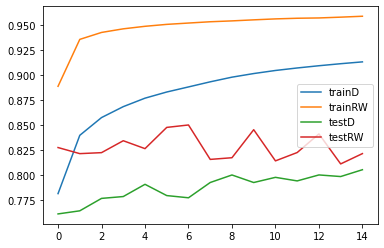

In [31]:
plt.plot(history.history['Delta_part_acc'], label='trainD')
plt.plot(history.history['RW_part_acc'], label='trainRW')
plt.plot(history.history['val_Delta_part_acc'], label='testD')
plt.plot(history.history['val_RW_part_acc'], label='testRW')
plt.legend()
plt.show()

In [32]:
'''
plt.plot(history.history['activation_48_acc'], label='trainD')
plt.plot(history.history['activation_49_acc'], label='trainRW')
plt.plot(history.history['val_activation_48_acc'], label='testD')
plt.plot(history.history['val_activation_49_acc'], label='testRW')
plt.legend()
plt.show()
'''

"\nplt.plot(history.history['activation_48_acc'], label='trainD')\nplt.plot(history.history['activation_49_acc'], label='trainRW')\nplt.plot(history.history['val_activation_48_acc'], label='testD')\nplt.plot(history.history['val_activation_49_acc'], label='testRW')\nplt.legend()\nplt.show()\n"

In [33]:
prediction = model.predict([trainX[:2,:],trainX_RW[:2,:]])
prediction

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[array([[[9.99989748e-01, 9.99966145e-01, 9.99972105e-01, 3.16190487e-03,
          9.97837007e-01, 1.10621295e-04, 1.44757137e-01, 9.83624339e-01,
          9.88545477e-01],
         [1.94121258e-05, 9.99070883e-01, 9.99772251e-01, 9.99999046e-01,
          9.99996901e-01, 9.99976516e-01, 9.99933004e-01, 9.99912262e-01,
          1.32118425e-04]],
 
        [[1.50504246e-04, 9.98102248e-01, 9.99187648e-01, 9.96469498e-01,
          9.99333203e-01, 9.99886513e-01, 9.99692321e-01, 9.99952435e-01,
          6.80438243e-04],
         [3.58761102e-02, 9.84406590e-01, 9.71165660e-04, 2.46898923e-03,
          9.87495005e-01, 9.94497836e-01, 3.09503525e-01, 9.84340310e-01,
          2.16743238e-02]]], dtype=float32), array([[[2.5283868e-04],
         [9.9999595e-01]],
 
        [[9.9355376e-01],
         [6.8914151e-04]]], dtype=float32)]

In [34]:
trainY[0:2]

array([[[1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0]],

       [[0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 1, 0]]])

In [35]:
testY_RW[0:2]

array([[[0],
        [0]],

       [[0],
        [1]]])

In [36]:
!pip3 install kmeans1d

     |████████████████████████████████| 93 kB 2.1 MB/s 


In [37]:
import kmeans1d

x = [4.0, 4.1, 4.2, -50, 200.2, 200.4, 200.9, 80, 100, 102]
k = 4

clusters, centroids = kmeans1d.cluster(x, k)

print(clusters)   # [1, 1, 1, 0, 3, 3, 3, 2, 2, 2]
print(centroids)  # [-50.0, 4.1, 94.0, 200.5]

[1, 1, 1, 0, 3, 3, 3, 2, 2, 2]
[-50.0, 4.1, 94.0, 200.5]
